In [1]:
import deepxde as dde
import numpy as np

Using backend: pytorch



Compiling model...
'compile' took 0.000395 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [6.95e-03, 1.65e-01, 0.00e+00, 1.00e+00]    [6.20e-03, 1.70e-01, 0.00e+00, 1.00e+00]    [1.12e+00]    
1000      [8.35e-03, 7.23e-03, 4.44e-08, 2.97e-04]    [9.39e-03, 7.20e-03, 4.44e-08, 2.97e-04]    [7.76e-01]    
2000      [5.89e-03, 4.58e-03, 7.92e-07, 1.38e-04]    [6.16e-03, 4.77e-03, 7.92e-07, 1.38e-04]    [6.37e-01]    
3000      [3.73e-03, 3.84e-03, 8.57e-07, 7.81e-05]    [3.88e-03, 4.07e-03, 8.57e-07, 7.81e-05]    [5.20e-01]    
4000      [1.39e-03, 1.83e-03, 1.07e-06, 2.59e-05]    [1.49e-03, 1.68e-03, 1.07e-06, 2.59e-05]    [3.05e-01]    
5000      [3.78e-04, 5.12e-04, 8.83e-07, 5.74e-06]    [4.22e-04, 3.71e-04, 8.83e-07, 5.74e-06]    [1.32e-01]    
6000      [2.52e-04, 2.08e-04, 5.69e-05, 3.62e-05]    [2.67e-04, 1.57e-04, 5.69e-05, 3.62e-05]    [5.77e-02]    
7000      [9.82e-05, 9.17e-05, 

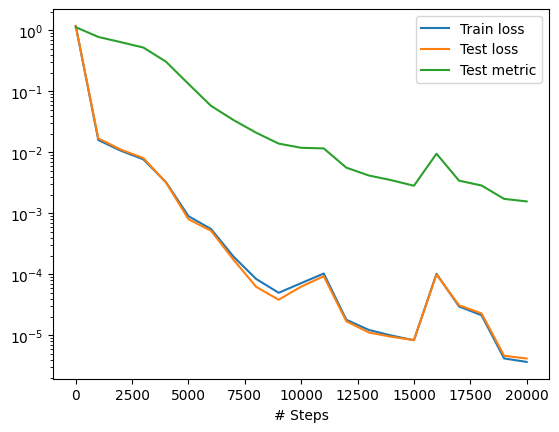

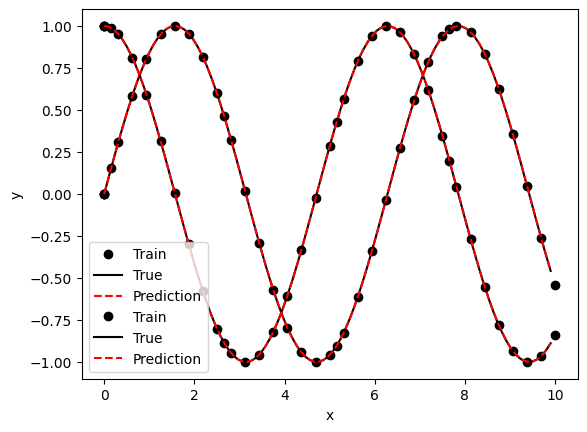

In [13]:
"""
指定几何区域，我理解的是定义域
"""
geom = dde.geometry.TimeDomain(0, 10)

"""
创建ODE系统，返回的就是残差值，与真实偏微分方程的差距
"""
def ode_system(x, y):
    """
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]

def boundary(_, on_initial):
    return on_initial

"""
initial condition
componet参数并未理解 
lambda函数就是
"""
ic1 = dde.icbc.IC(geom, lambda x : 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x : 1, boundary, component=1)

"""
真是解，应该是为了评估模型
"""
def func(x):
    return np.hstack((np.sin(x), np.cos(x)))

data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)



layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)



In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf

Using backend: pytorch



In [ ]:
U = 200
R = 20

geom = dde.geometry.TimeDomain(0.0, 1.0)

def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    # r，t对x的一阶偏导
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - R/U * (2.0 * U * r - 0.04 * U * U * r * p),
        dp_t - R/U * (0.02 * U * U * r * p - 1.06 * U * p)
    ]

def boundary(_, on_initial):
    return on_initial

# 在t=0出，r与p的计算公式由匿名函数表出
ic1 = dde.icbc.DirichletBC(geom, lambda x : 100/U, boundary, component=0)
ic2 = dde.icbc.DirichletBC(geom, lambda x : 15/U, boundary, component=1)

data = dde.data.PDE(geom, ode_system, [ic1, ic2], 3000, 2, train_distribution="uniform", num_test=4000)

def func(t, y):
    r, p = y
    dr_t = R/U * (2.0 * U * r - 0.04 * U * U * r * p)
    dp_t = R/U * (0.02 * U * U * r * p - 1.06 * U * p )
    return dr_t, dp_t

def gen_truedata(t = np.linspace(0, 1, 100)):
    sol = integrate.solve_ivp(func, (0, 10), (100 / U, 15 / U), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(len(t), 1)
    y_true = y_true.reshape(len(t), 1)

    return x_true, y_true



In [5]:
help(dde.data.PDE.train_next_batch)

Help on function train_next_batch in module deepxde.data.pde:

train_next_batch(self, batch_size=None)
    Return a training dataset of the size `batch_size`.



## 劳伦兹混沌系统
$$ 
\large 
\begin{cases}
\frac{dx}{dt} = \sigma(y-x), \\
\frac{dy}{dt} = \rho x - y -x z, \\\
\frac{dz}{dt} = x y - \beta z, \\
\end {cases} \\ 
\large \sigma = 10, \beta = 8/3, \rho = 28, t \in [0, 500]
$$

初始条件$\large x(0) = 10^{-5}, y(0) = 0, z(0) = 0.$

In [11]:
import deepxde as dde
import numpy as np

In [29]:
sigma = 10
beta = 8./3
rho = 28
def ode_system(t, y_list):
    x, y, z = y_list[:,0:1], y_list[:,1:2], y_list[:,2:]
    dx_t = dde.grad.jacobian(y_list, t, i=0)
    dy_t = dde.grad.jacobian(y_list, t, i=1)
    dz_t = dde.grad.jacobian(y_list, t, i=2)
    return [scale*dx_t-sigma*(y-x), scale*dy_t-rho*x+y+x*z, scale*dz_t-x*y+beta*z]

def boundary(_, on_initial):
    return on_initial

scale = 500

geom = dde.geometry.TimeDomain(0, 1.)
ic1 = dde.icbc.IC(geom, lambda x : 1e-5, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)

num_domain = 60 * scale
num_boundary = 3
num_test = 60 * scale

data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3], num_domain=num_domain,
                   num_boundary=num_boundary, num_test=num_test,
                   train_distribution="uniform")


In [25]:
layer_size = [1] + [100] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [30]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000390 s



In [32]:
losshistory, train_state = model.train(epochs=200)

Training model...

1242      [1.09e-03, 4.75e-03, 2.97e-03, 1.31e-03, 1.04e-03, 1.23e-03]    [1.09e-03, 4.75e-03, 2.97e-03, 1.31e-03, 1.04e-03, 1.23e-03]    []  
1442      [9.46e-04, 4.15e-03, 2.15e-03, 1.24e-03, 7.52e-04, 1.00e-03]    [9.46e-04, 4.15e-03, 2.15e-03, 1.24e-03, 7.52e-04, 1.00e-03]    []  

Best model at step 1442:
  train loss: 1.02e-02
  test loss: 1.02e-02
  test metric: []

'train' took 160.835716 s

